C:\Users\tonhanhgia\AppData\Local\Temp\ipykernel_19296\1489793781.py:58: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  customers = pd.read_csv(
C:\Users\tonhanhgia\AppData\Local\Temp\ipykernel_19296\1489793781.py:63: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  interactions = pd.read_csv(


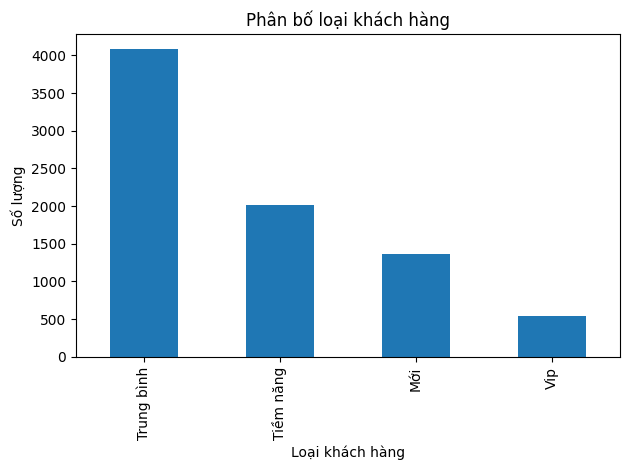

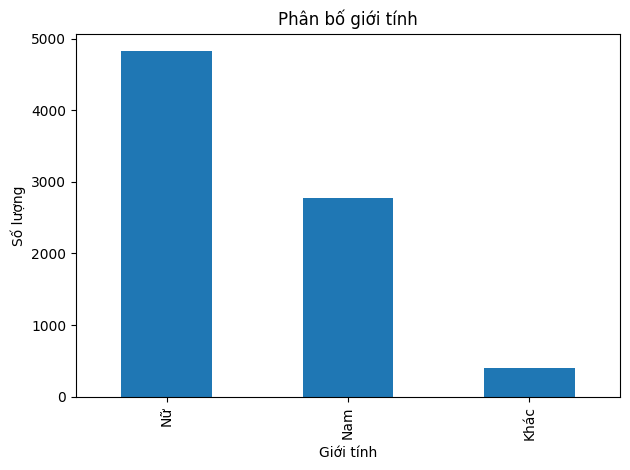

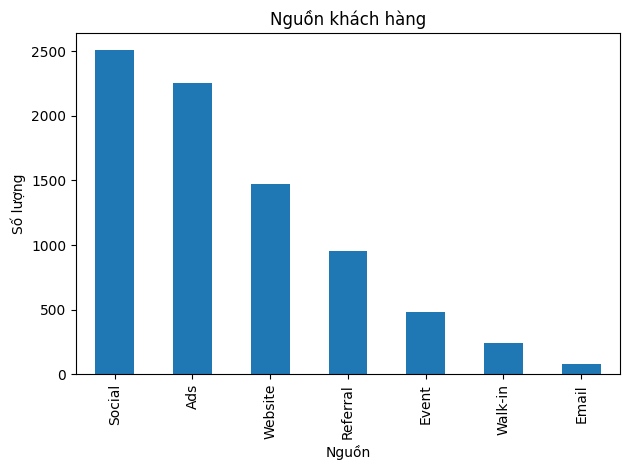

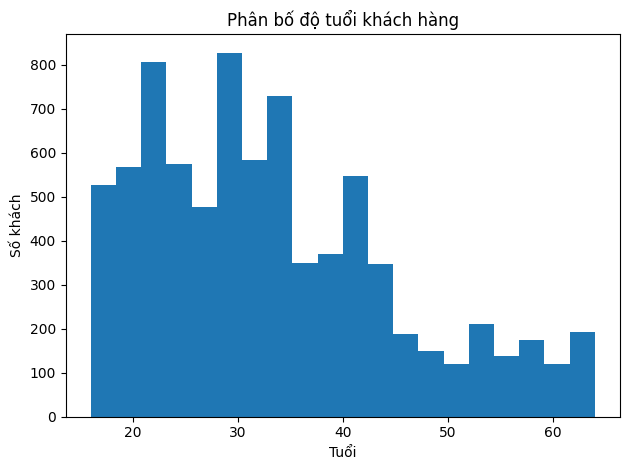

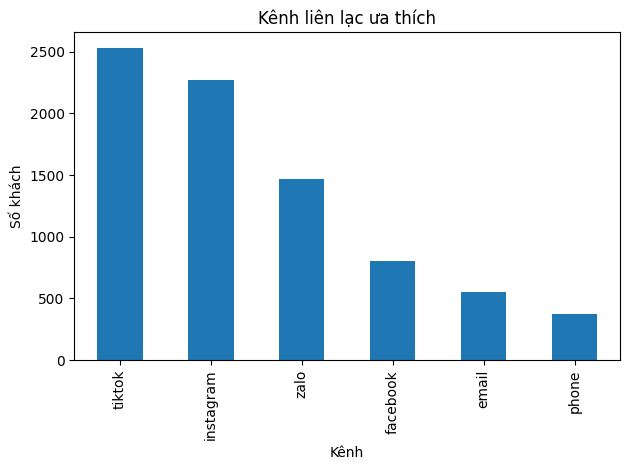

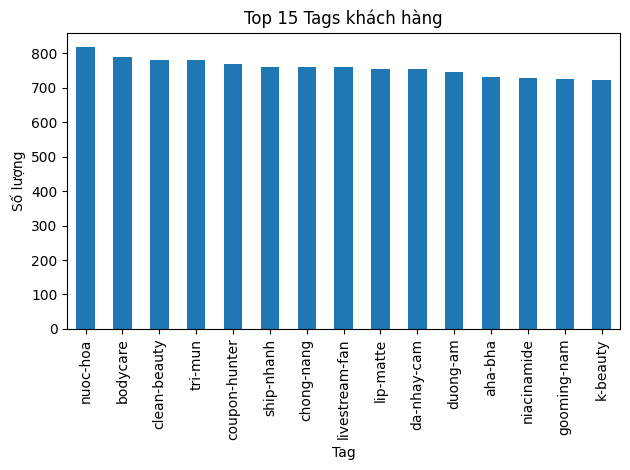

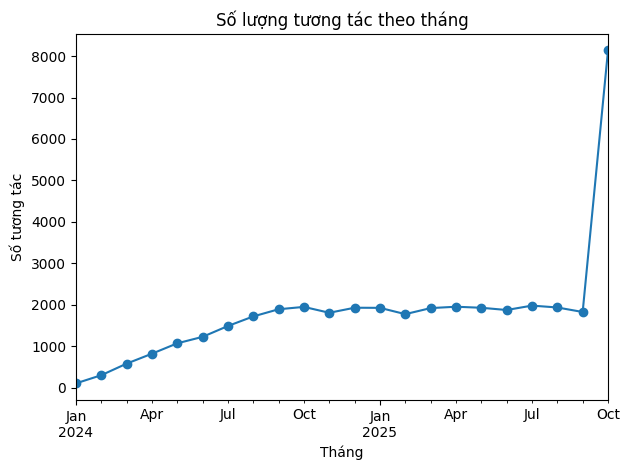

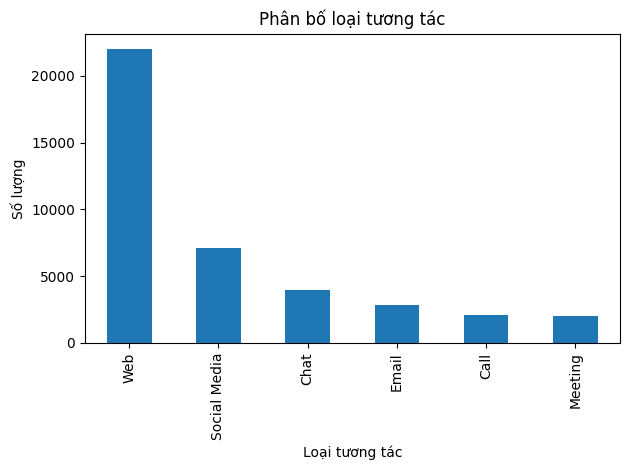

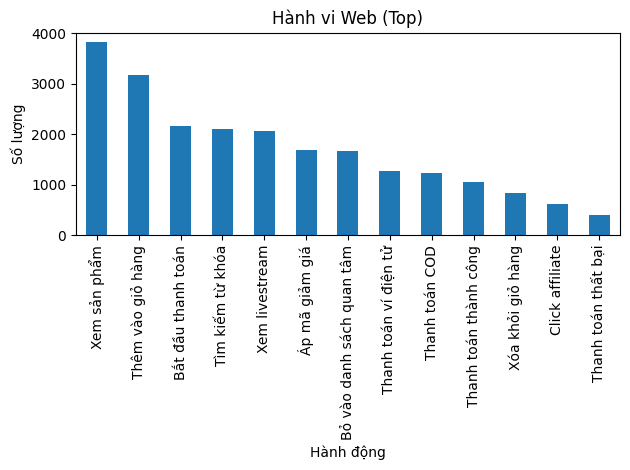

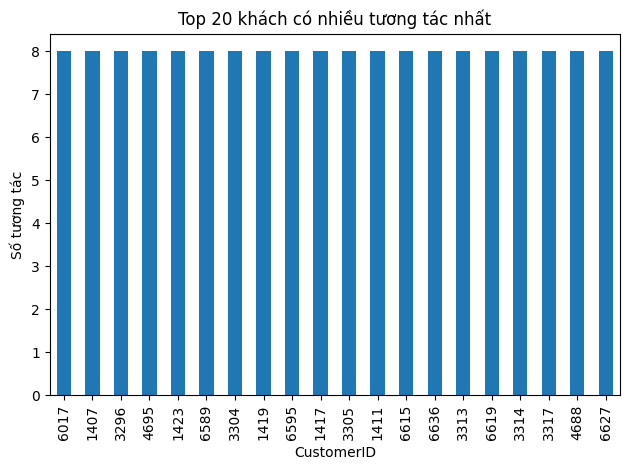


=== KPI TỔNG QUAN ===
 Số khách hàng  Tỷ lệ Vip (%)  Tuổi TB  Số tương tác  Tương tác/khách (TB)
          8000           6.75    33.34         40091                  5.01

=== Preview hành vi Web (100 dòng) ===
 customer_id            datetime                    action
           1 2024-07-25 18:11:20     Thanh toán thành công
           1 2024-04-21 02:59:32          Tìm kiếm từ khóa
           2 2024-09-19 23:49:57        Bắt đầu thanh toán
           2 2024-09-06 14:01:28        Bắt đầu thanh toán
           2 2024-09-28 16:51:46     Thanh toán ví điện tử
           2 2024-06-15 07:33:36              Xem sản phẩm
           3 2025-07-11 16:26:31         Thêm vào giỏ hàng
           3 2025-10-09 09:55:00 Bỏ vào danh sách quan tâm
           3 2025-06-06 17:10:34            Xem livestream
           4 2025-02-24 08:02:49            Xem livestream
           4 2025-03-10 05:28:27        Bắt đầu thanh toán
           4 2024-09-27 17:11:09       Thanh toán thất bại
           5 2025-05

In [2]:

import os
import json
from collections import Counter
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ========= CẤU HÌNH =========
CUSTOMERS_CSV = "customers_8000_v2025.csv"     # <-- Đổi sang đường dẫn file Customers của bạn
INTERACTIONS_CSV = "interactions_v2025.csv"    # <-- Đổi sang đường dẫn file Interactions của bạn
OUT_DIR = "charts_out"                    # nơi lưu ảnh biểu đồ (tùy chọn)

TODAY = datetime(2025, 10, 9)             # mốc thời gian nhất quán để tính tuổi


# ========= HÀM PHỤ =========
def ensure_outdir(path):
    os.makedirs(path, exist_ok=True)

def safe_parse_json(val):
    if pd.isna(val):
        return {}
    try:
        return json.loads(val)
    except Exception:
        return {}

def compute_age(birth_date_col, today: datetime):
    ages = []
    for d in birth_date_col:
        if pd.isna(d):
            ages.append(np.nan)
        else:
            years = today.year - d.year - ((today.month, today.day) < (d.month, d.day))
            ages.append(years)
    return pd.Series(ages)

def extract_action(note: str):
    # kỳ vọng pattern trong notes của tương tác Web: hành_động='...';
    if not isinstance(note, str):
        return None
    key = "hành_động='"
    start = note.find(key)
    if start == -1:
        return None
    start += len(key)
    end = note.find("'", start)
    if end == -1:
        return None
    return note[start:end]


# ========= LOAD DỮ LIỆU =========
def load_data(customers_csv, interactions_csv):
    customers = pd.read_csv(
        customers_csv,
        parse_dates=["created_at", "updated_at", "birth_date"],
        infer_datetime_format=True
    )
    interactions = pd.read_csv(
        interactions_csv,
        parse_dates=["datetime"],
        infer_datetime_format=True
    )
    return customers, interactions


# ========= VIZ & KPI =========
def make_plots(customers: pd.DataFrame, interactions: pd.DataFrame, out_dir=None):
    # Tiền xử lý
    customers["age"] = compute_age(customers["birth_date"], TODAY)

    # Tách preferred channel + tags
    social_pref = []
    tag_flat = []

    for _, row in customers.iterrows():
        s = safe_parse_json(row.get("social_channels", "{}"))
        t = safe_parse_json(row.get("tags", "[]"))

        pref = s.get("preferred", None) if isinstance(s, dict) else None
        social_pref.append(pref)

        if isinstance(t, list):
            tag_flat.extend([x for x in t if isinstance(x, str)])
        elif isinstance(t, dict):
            tag_flat.extend([str(v) for v in t.values()])

    customers["preferred_channel"] = social_pref

    ensure_outdir(out_dir) if out_dir else None

    # 1) Phân bố loại khách hàng
    plt.figure()
    customers["customer_type"].value_counts(dropna=False).sort_values(ascending=False).plot(kind="bar")
    plt.title("Phân bố loại khách hàng")
    plt.xlabel("Loại khách hàng")
    plt.ylabel("Số lượng")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "01_customer_type.png"), dpi=150)
    plt.show()

    # 2) Giới tính
    plt.figure()
    customers["gender"].value_counts(dropna=False).plot(kind="bar")
    plt.title("Phân bố giới tính")
    plt.xlabel("Giới tính")
    plt.ylabel("Số lượng")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "02_gender.png"), dpi=150)
    plt.show()

    # 3) Nguồn khách hàng
    plt.figure()
    customers["source"].value_counts(dropna=False).plot(kind="bar")
    plt.title("Nguồn khách hàng")
    plt.xlabel("Nguồn")
    plt.ylabel("Số lượng")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "03_source.png"), dpi=150)
    plt.show()

    # 4) Tuổi (histogram)
    plt.figure()
    customers["age"].dropna().astype(int).plot(kind="hist", bins=20)
    plt.title("Phân bố độ tuổi khách hàng")
    plt.xlabel("Tuổi")
    plt.ylabel("Số khách")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "04_age_hist.png"), dpi=150)
    plt.show()

    # 5) Kênh liên lạc ưa thích
    plt.figure()
    customers["preferred_channel"].value_counts(dropna=True).plot(kind="bar")
    plt.title("Kênh liên lạc ưa thích")
    plt.xlabel("Kênh")
    plt.ylabel("Số khách")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "05_preferred_channel.png"), dpi=150)
    plt.show()

    # 6) Top tags
    tag_counts = Counter([t for t in tag_flat if t.strip()])
    top_tags = pd.Series(dict(tag_counts.most_common(15)))
    plt.figure()
    top_tags.plot(kind="bar")
    plt.title("Top 15 Tags khách hàng")
    plt.xlabel("Tag")
    plt.ylabel("Số lượng")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "06_top_tags.png"), dpi=150)
    plt.show()

    # 7) Tương tác theo tháng
    interactions["month"] = interactions["datetime"].dt.to_period("M").dt.to_timestamp()
    monthly_counts = interactions.groupby("month")["interaction_id"].count()
    plt.figure()
    monthly_counts.plot(kind="line", marker="o")
    plt.title("Số lượng tương tác theo tháng")
    plt.xlabel("Tháng")
    plt.ylabel("Số tương tác")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "07_interactions_monthly.png"), dpi=150)
    plt.show()

    # 8) Loại tương tác
    plt.figure()
    interactions["interaction_type"].value_counts().plot(kind="bar")
    plt.title("Phân bố loại tương tác")
    plt.xlabel("Loại tương tác")
    plt.ylabel("Số lượng")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "08_interaction_types.png"), dpi=150)
    plt.show()

    # 9) Hành vi Web (funnel hành động)
    web = interactions[interactions["interaction_type"] == "Web"].copy()
    web["action"] = web["notes"].apply(extract_action)
    action_counts = web["action"].value_counts().head(15)
    plt.figure()
    action_counts.plot(kind="bar")
    plt.title("Hành vi Web (Top)")
    plt.xlabel("Hành động")
    plt.ylabel("Số lượng")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "09_web_actions.png"), dpi=150)
    plt.show()

    # 10) Top 20 khách có nhiều tương tác nhất
    top_int = interactions.groupby("customer_id")["interaction_id"].count().sort_values(ascending=False).head(20)
    plt.figure()
    top_int.plot(kind="bar")
    plt.title("Top 20 khách có nhiều tương tác nhất")
    plt.xlabel("CustomerID")
    plt.ylabel("Số tương tác")
    plt.tight_layout()
    if out_dir: plt.savefig(os.path.join(out_dir, "10_top_customers_interactions.png"), dpi=150)
    plt.show()

    # KPI tổng quan
    kpis = pd.DataFrame({
        "Số khách hàng": [customers.shape[0]],
        "Tỷ lệ Vip (%)": [round(100 * (customers["customer_type"] == "Vip").mean(), 2)],
        "Tuổi TB": [round(customers["age"].mean(), 2)],
        "Số tương tác": [interactions.shape[0]],
        "Tương tác/khách (TB)": [round(interactions.shape[0] / max(customers.shape[0], 1), 2)],
    })
    print("\n=== KPI TỔNG QUAN ===")
    print(kpis.to_string(index=False))

    # Preview hành vi Web (100 dòng)
    print("\n=== Preview hành vi Web (100 dòng) ===")
    print(web[["customer_id", "datetime", "action"]].head(100).to_string(index=False))


def main():
    customers, interactions = load_data(CUSTOMERS_CSV, INTERACTIONS_CSV)
    make_plots(customers, interactions, OUT_DIR)


if __name__ == "__main__":
    main()



=== UNIQUE SUMMARY (top 20 rows) ===
        table                 column   dtype  n_unique  n_null                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             example_values
       orders ai_suggested_crosssell  object      6408       0 [{"product_id": "Dầu Gội Khô Spes Dạng Xịt Hương Bưởi 150ml", "title": "Spes"}], [{"product_id": "Sữa Rửa Mặt Nivea Dạng Gel Tạo Bọt Sạch Sâu Ngừa Mụn 90ml", "title": "Nivea"}], [{"prod

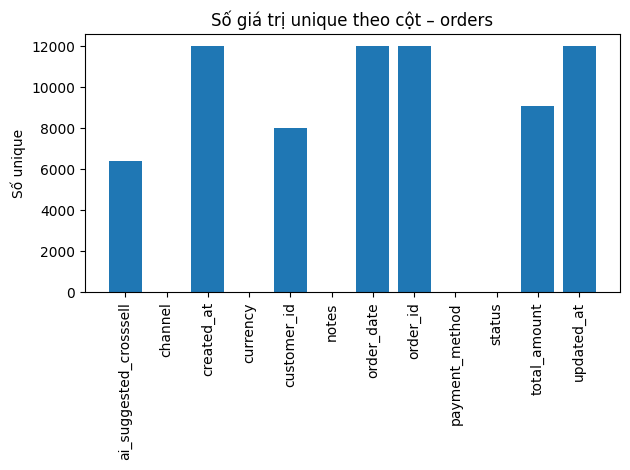

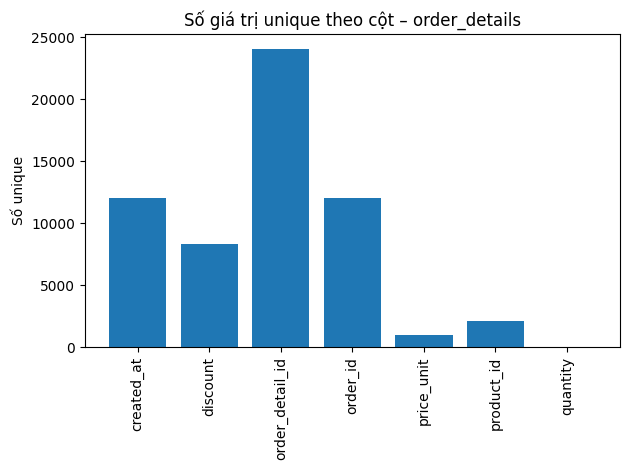

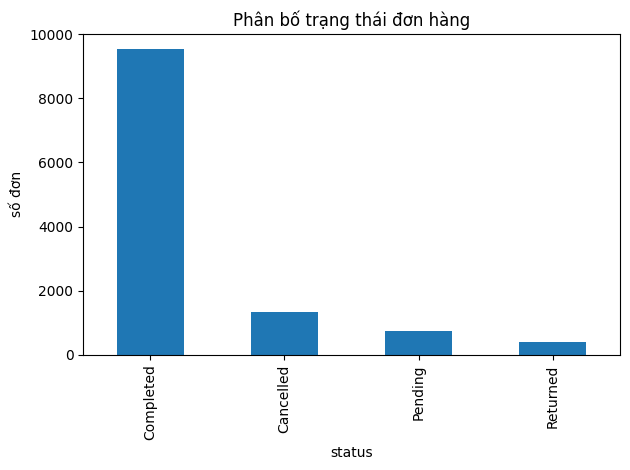

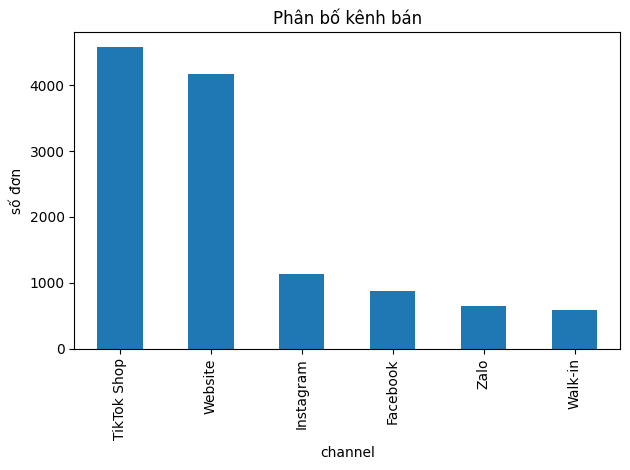

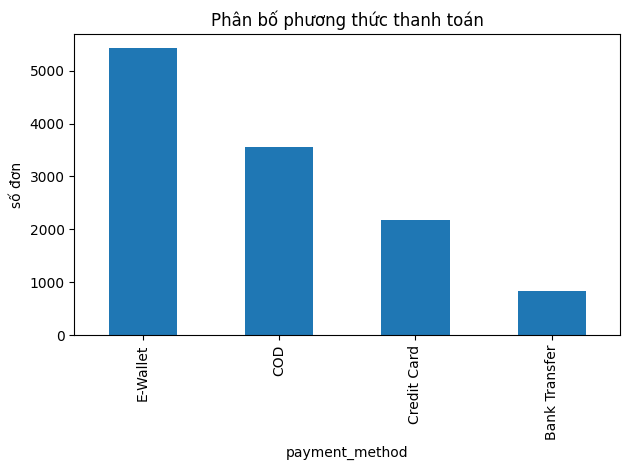

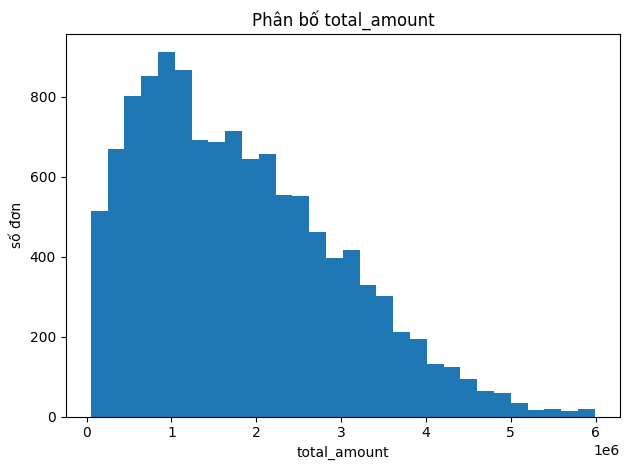

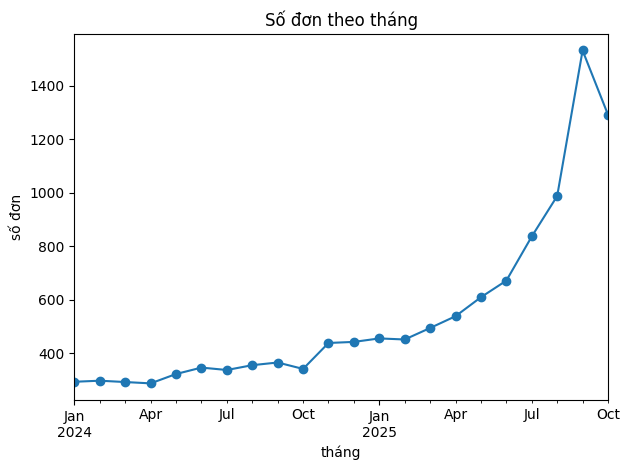

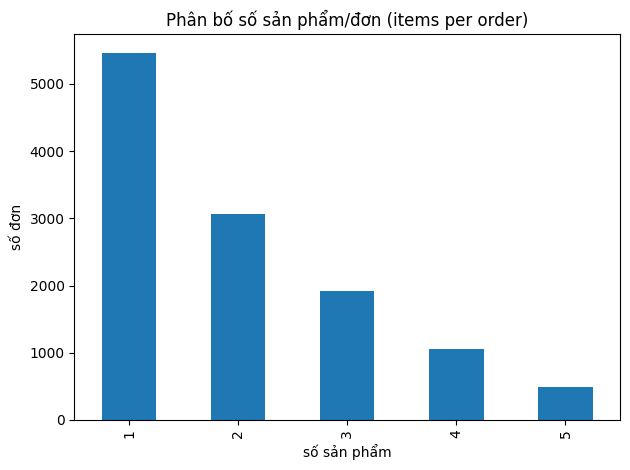

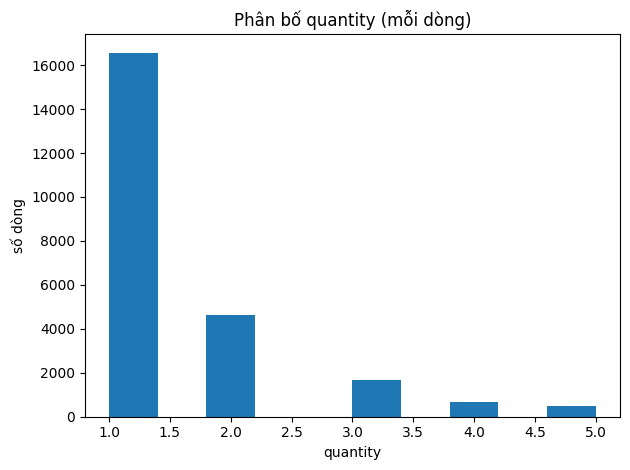

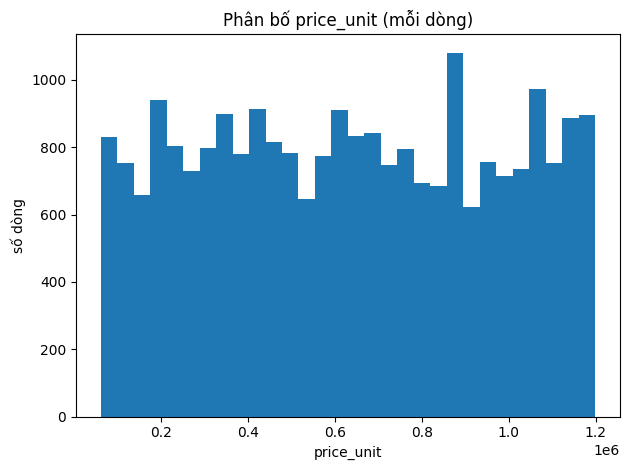


=== CHECKS ===
số đơn khác nhau: 12000
số dòng chi tiết: 24054
trung bình số sản phẩm/đơn: 2.00


In [3]:
# eda_orders.py
# Trực quan + kiểm tra unique cho orders.csv & order_details.csv
# Yêu cầu: pandas, matplotlib

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========= CẤU HÌNH =========
ORDERS_CSV = "orders_v2.csv"
DETAILS_CSV = "order_details_v2.csv"
SAVE_DIR = "eda_charts"
SAVE_IMAGES = True  # False nếu không muốn lưu ảnh

def ensure_dir(d):
    if SAVE_IMAGES:
        os.makedirs(d, exist_ok=True)

def savefig(name):
    if SAVE_IMAGES:
        plt.savefig(os.path.join(SAVE_DIR, name), dpi=150, bbox_inches="tight")

def summarize_uniques(df: pd.DataFrame, name: str) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)
        n_unique = s.nunique(dropna=True)
        n_null = int(s.isna().sum())
        sample_vals = (
            s.dropna().astype(str).head(5).tolist() if not s.dropna().empty else []
        )
        rows.append({
            "table": name,
            "column": col,
            "dtype": dtype,
            "n_unique": int(n_unique),
            "n_null": n_null,
            "example_values": ", ".join(sample_vals)
        })
    out = pd.DataFrame(rows).sort_values(["table", "column"]).reset_index(drop=True)
    return out

def bar_unique(df_summary: pd.DataFrame, table_name: str):
    sub = df_summary[df_summary["table"] == table_name]
    plt.figure()
    x = np.arange(len(sub))
    plt.bar(x, sub["n_unique"].values)
    plt.title(f"Số giá trị unique theo cột – {table_name}")
    plt.xticks(x, sub["column"].tolist(), rotation=90)
    plt.ylabel("Số unique")
    plt.tight_layout()
    savefig(f"{table_name.lower()}_unique_per_column.png")
    plt.show()

def plot_basic_orders(orders: pd.DataFrame):
    # 1) Phân bố trạng thái
    plt.figure()
    orders["status"].value_counts().plot(kind="bar")
    plt.title("Phân bố trạng thái đơn hàng")
    plt.xlabel("status"); plt.ylabel("số đơn")
    plt.tight_layout(); savefig("orders_status.png"); plt.show()

    # 2) Kênh bán
    plt.figure()
    orders["channel"].value_counts().plot(kind="bar")
    plt.title("Phân bố kênh bán")
    plt.xlabel("channel"); plt.ylabel("số đơn")
    plt.tight_layout(); savefig("orders_channel.png"); plt.show()

    # 3) Phương thức thanh toán
    plt.figure()
    orders["payment_method"].value_counts().plot(kind="bar")
    plt.title("Phân bố phương thức thanh toán")
    plt.xlabel("payment_method"); plt.ylabel("số đơn")
    plt.tight_layout(); savefig("orders_payment.png"); plt.show()

    # 4) Tổng tiền (hist)
    plt.figure()
    orders["total_amount"].dropna().astype(float).plot(kind="hist", bins=30)
    plt.title("Phân bố total_amount")
    plt.xlabel("total_amount"); plt.ylabel("số đơn")
    plt.tight_layout(); savefig("orders_total_amount_hist.png"); plt.show()

    # 5) Đơn theo tháng
    if "order_date" in orders.columns:
        dt = pd.to_datetime(orders["order_date"], errors="coerce")
        month = dt.dt.to_period("M").dt.to_timestamp()
        plt.figure()
        month.value_counts().sort_index().plot(kind="line", marker="o")
        plt.title("Số đơn theo tháng")
        plt.xlabel("tháng"); plt.ylabel("số đơn")
        plt.tight_layout(); savefig("orders_by_month.png"); plt.show()

def plot_basic_details(details: pd.DataFrame):
    # 1) Số dòng chi tiết theo đơn (items per order)
    cnt = details.groupby("order_id").size()
    plt.figure()
    cnt.value_counts().sort_index().plot(kind="bar")
    plt.title("Phân bố số sản phẩm/đơn (items per order)")
    plt.xlabel("số sản phẩm"); plt.ylabel("số đơn")
    plt.tight_layout(); savefig("details_items_per_order.png"); plt.show()

    # 2) Số lượng (quantity) histogram
    if "quantity" in details.columns:
        plt.figure()
        details["quantity"].dropna().astype(int).plot(kind="hist", bins=10)
        plt.title("Phân bố quantity (mỗi dòng)")
        plt.xlabel("quantity"); plt.ylabel("số dòng")
        plt.tight_layout(); savefig("details_quantity_hist.png"); plt.show()

    # 3) Giá đơn vị (price_unit) histogram
    if "price_unit" in details.columns:
        plt.figure()
        details["price_unit"].dropna().astype(float).plot(kind="hist", bins=30)
        plt.title("Phân bố price_unit (mỗi dòng)")
        plt.xlabel("price_unit"); plt.ylabel("số dòng")
        plt.tight_layout(); savefig("details_price_unit_hist.png"); plt.show()

def main():
    ensure_dir(SAVE_DIR)

    # ----- Load -----
    orders = pd.read_csv(ORDERS_CSV)
    details = pd.read_csv(DETAILS_CSV)

    # ----- Unique summary -----
    sum_orders = summarize_uniques(orders, "orders")
    sum_details = summarize_uniques(details, "order_details")
    summary = pd.concat([sum_orders, sum_details], ignore_index=True)
    print("\n=== UNIQUE SUMMARY (top 20 rows) ===")
    print(summary.head(20).to_string(index=False))

    # Lưu bảng summary ra CSV (tiện audit)
    summary.to_csv("unique_summary_orders_details.csv", index=False, encoding="utf-8")
    print("\nĐã lưu: unique_summary_orders_details.csv")

    # ----- Biểu đồ -----
    bar_unique(summary, "orders")
    bar_unique(summary, "order_details")
    plot_basic_orders(orders)
    plot_basic_details(details)

    # Một số chỉ số bổ sung
    print("\n=== CHECKS ===")
    n_orders = orders["order_id"].nunique()
    n_lines = details.shape[0]
    avg_items = n_lines / max(n_orders, 1)
    print(f"số đơn khác nhau: {n_orders}")
    print(f"số dòng chi tiết: {n_lines}")
    print(f"trung bình số sản phẩm/đơn: {avg_items:.2f}")

if __name__ == "__main__":
    main()
